In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import sys
import gc
import tensorflow as tf
from random import randint
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold, datasets
from IPython.display import clear_output


(480, 640, 3)


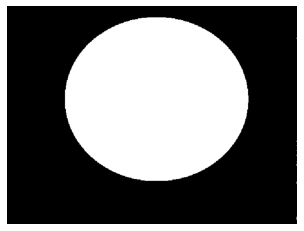

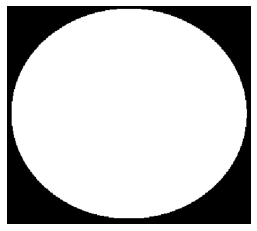

In [2]:
# read mask
mask = np.array(cv2.imread('mask.png'))/255
mask[mask>0] = 1
print(mask.shape)
plt.imshow(mask,plt.cm.gray)
plt.axis("off");plt.show()

plt.imshow(mask[20:-85,120:-100],plt.cm.gray)
plt.axis("off");plt.show()

## check mask's white is 1
# temp = mask
# temp[temp==1] = 0
# plt.imshow(mask,plt.cm.gray)
# plt.axis("off");plt.show()

# read file for `white` picture

In [3]:
def read_while_file():
    print("reading data of white...")
    file_path='d:/Special_topic/pleurotus_eryngii/white/*'
    file_name = glob.glob(file_path)
    file_num = len(file_name)

    data = np.zeros((file_num,375,420,3),dtype=np.uint8)

    for i in range(file_num):
        data[i] = (cv2.imread(file_name[i]) * mask )[20:-85,120:-100]

    ## plot image for white data
    # plt.figure(figsize=(10,5))
    # for i in range(file_num):
    #     plt.subplot(3,3,i+1)
    #     plt.axis("off")
    #     plt.title(file_name[i])
    #     plt.imshow(cv2.cvtColor(data[i], cv2.COLOR_BGR2RGB))
    # plt.show()

    print("reading data of white sucessful\n")
    return data


white_data = read_while_file()


reading data of white...
reading data of white sucessful



# read file for `data` picture

In [4]:
def read_data_file():
    print("reading data....")

    ## read file path
    ## file path 1030 1104 1108 1118 1122
    file_path='d:/Special_topic/pleurotus_eryngii/*'
    folder_name = glob.glob(file_path)[:5]
    file_name=[]
    for folder_name in folder_name:
        count = 0
        for fname in glob.glob(folder_name+"/*"):
            file_name.append(fname)
            count+=1
            if(count==9*5):
                pass
                # break
    print("file_name number: ",len(file_name))
    print("data all Group number: ",len(file_name)//9)

    data_Gnum = len(file_name)//9
    print("data_Gnum = ", data_Gnum)

    ## [data_Gnum][NumOfPicture][picture(480*640*wave)]
    data_black = np.zeros((data_Gnum,375,420,9),dtype=np.uint8)
    data       = np.zeros((data_Gnum,375,420,18),dtype=np.uint8)
    print("data_black.shpae = ",data_black.shape)
    print("data.shpae = ",data.shape)
    collected = gc.collect()
    print("Garbage collector: collected %d objects." % (collected))

    print("processing group")
    for group in range(data_Gnum):
        print("{}/{}".format(group+1,data_Gnum),end="\t")

        for black in range(3):
            img = cv2.imread(file_name[group*9+black]) * mask
            data_black[group][:,:,black*3:black*3+3] = img[20:-85,120:-100]

        for LED in range(6):
            img = cv2.imread(file_name[group*9+3+LED]) * mask
            data[group][:,:,LED*3:LED*3+3] = img[20:-85,120:-100]

    gc.collect()
    print("\nreading data sucessful\n")
    return data, data_black, data_Gnum

#=========================================================
data, data_black, data_Gnum = read_data_file()
print("data.type = ",type(data[0][0][0][0]))
print("data max = ", np.amax(data))
print("data max = ", np.amin(data))



reading data....
file_name number:  1296
data all Group number:  144
data_Gnum =  144
data_black.shpae =  (144, 375, 420, 9)
data.shpae =  (144, 375, 420, 18)
Garbage collector: collected 4722 objects.
processing group
1/144	2/144	3/144	4/144	5/144	6/144	7/144	8/144	9/144	10/144	11/144	12/144	13/144	14/144	15/144	16/144	17/144	18/144	19/144	20/144	21/144	22/144	23/144	24/144	25/144	26/144	27/144	28/144	29/144	30/144	31/144	32/144	33/144	34/144	35/144	36/144	37/144	38/144	39/144	40/144	41/144	42/144	43/144	44/144	45/144	46/144	47/144	48/144	49/144	50/144	51/144	52/144	53/144	54/144	55/144	56/144	57/144	58/144	59/144	60/144	61/144	62/144	63/144	64/144	65/144	66/144	67/144	68/144	69/144	70/144	71/144	72/144	73/144	74/144	75/144	76/144	77/144	78/144	79/144	80/144	81/144	82/144	83/144	84/144	85/144	86/144	87/144	88/144	89/144	90/144	91/144	92/144	93/144	94/144	95/144	96/144	97/144	98/144	99/144	100/144	101/144	102/144	103/144	104/144	105/144	106/144	107/144	108/144	109/144	110/144	111/144	1

In [5]:
# solve div0 question

# def div0( a, b ):
#     """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
#     with np.errstate(divide='ignore', invalid='ignore'):
#         c = np.divide(a,b)
#         c[ ~ np.isfinite( c )] = 0  # -inf inf NaN
#     return c

def div0(a,b):
    b[b==0] = -1
    c = a/b
    c[c<0] = 0
    return c

def print_info(img):
    print("max =",np.amax(img))
    print("min =",np.amin(img))
    print("mean=",np.mean(img))

a = np.array([1.,0.,0.], dtype='float')
b = np.array([0.,1.,0.], dtype='float')
c = div0(a,b)
print(div0(a,b))

[ 0.  0. -0.]


# calculate reflectivity

In [6]:
## initialization
# [data_Gnum][NumOfPicture(LED)][picture(480*640*3)]
data = data.astype('float')
white_data = white_data.astype('float')
reflectivity = np.zeros_like(data, dtype='float')
print("reflectivity.shape=", reflectivity.shape)
print()

dark_30 = white_data[2]
dark_40 = white_data[0]
dark_100= white_data[1]
# print("dark_100.shape=",dark_100.shape)

LED1_white = white_data[3]
LED2_white = white_data[4]
LED3_white = white_data[5]
LED4_white = white_data[5]
LED5_white = white_data[7]
LED6_white = white_data[8]
# print("LED6_white.shape=",LED6_whdef array_divide(a,b):

print(type(dark_30[0][0][0]))


reflectivity.shape= (144, 375, 420, 18)

<class 'numpy.float64'>


In [7]:
# deal reflectivity
for Gnum in range(data_Gnum):
    LED = np.zeros((6,375,420,3),dtype=np.float)
    for i in range(6):
        LED[i] = data[Gnum][:,:,i*3:i*3+3]

    reflectivity[Gnum][:,:,0:3]   = div0((LED[0]-dark_40) , (LED1_white-dark_40))
    reflectivity[Gnum][:,:,3:6]   = div0((LED[1]-dark_30) , (LED2_white-dark_30))
    reflectivity[Gnum][:,:,6:9]   = div0((LED[2]-dark_30) , (LED3_white-dark_30))
    reflectivity[Gnum][:,:,9:12]  = div0((LED[3]-dark_30) , (LED4_white-dark_30))
    reflectivity[Gnum][:,:,12:15] = div0((LED[4]-dark_30) , (LED5_white-dark_30))
    reflectivity[Gnum][:,:,15:]   = div0((LED[5]-dark_100), (LED6_white-dark_100))
    gc.collect()

    print("{}/{}\t".format(Gnum, data_Gnum),end="")

reflectivity[reflectivity<0] = 0
reflectivity[reflectivity>1] = 1
print("\nprocess sucessful\n")


0/144	1/144	2/144	3/144	4/144	5/144	6/144	7/144	8/144	9/144	10/144	11/144	12/144	13/144	14/144	15/144	16/144	17/144	18/144	19/144	20/144	21/144	22/144	23/144	24/144	25/144	26/144	27/144	28/144	29/144	30/144	31/144	32/144	33/144	34/144	35/144	36/144	37/144	38/144	39/144	40/144	41/144	42/144	43/144	44/144	45/144	46/144	47/144	48/144	49/144	50/144	51/144	52/144	53/144	54/144	55/144	56/144	57/144	58/144	59/144	60/144	61/144	62/144	63/144	64/144	65/144	66/144	67/144	68/144	69/144	70/144	71/144	72/144	73/144	74/144	75/144	76/144	77/144	78/144	79/144	80/144	81/144	82/144	83/144	84/144	85/144	86/144	87/144	88/144	89/144	90/144	91/144	92/144	93/144	94/144	95/144	96/144	97/144	98/144	99/144	100/144	101/144	102/144	103/144	104/144	105/144	106/144	107/144	108/144	109/144	110/144	111/144	112/144	113/144	114/144	115/144	116/144	117/144	118/144	119/144	120/144	121/144	122/144	123/144	124/144	125/144	126/144	127/144	128/144	129/144	130/144	131/144	132/144	133/144	134/144	135/144	136/144	137/144	138/14

In [8]:
del LED
del white_data, LED1_white, LED2_white, LED3_white, LED4_white, LED5_white, LED6_white
del dark_100, dark_30, dark_40
del data, data_black
%whos

Variable          Type        Data/Info
---------------------------------------
Gnum              int         143
PCA               ABCMeta     <class 'sklearn.decomposition._pca.PCA'>
StandardScaler    type        <class 'sklearn.preproces<...>ng._data.StandardScaler'>
a                 ndarray     3: 3 elems, type `float64`, 24 bytes
animation         module      <module 'matplotlib.anima<...>atplotlib\\animation.py'>
b                 ndarray     3: 3 elems, type `float64`, 24 bytes
c                 ndarray     3: 3 elems, type `float64`, 24 bytes
clear_output      function    <function clear_output at 0x00000299E3B98948>
cv2               module      <module 'cv2.cv2' from 'C<...>\cv2.cp37-win_amd64.pyd'>
data_Gnum         int         144
datasets          module      <module 'sklearn.datasets<...>\\datasets\\__init__.py'>
div0              function    <function div0 at 0x00000299F1780798>
gc                module      <module 'gc' (built-in)>
glob              module      <module

 group 0 ==================================


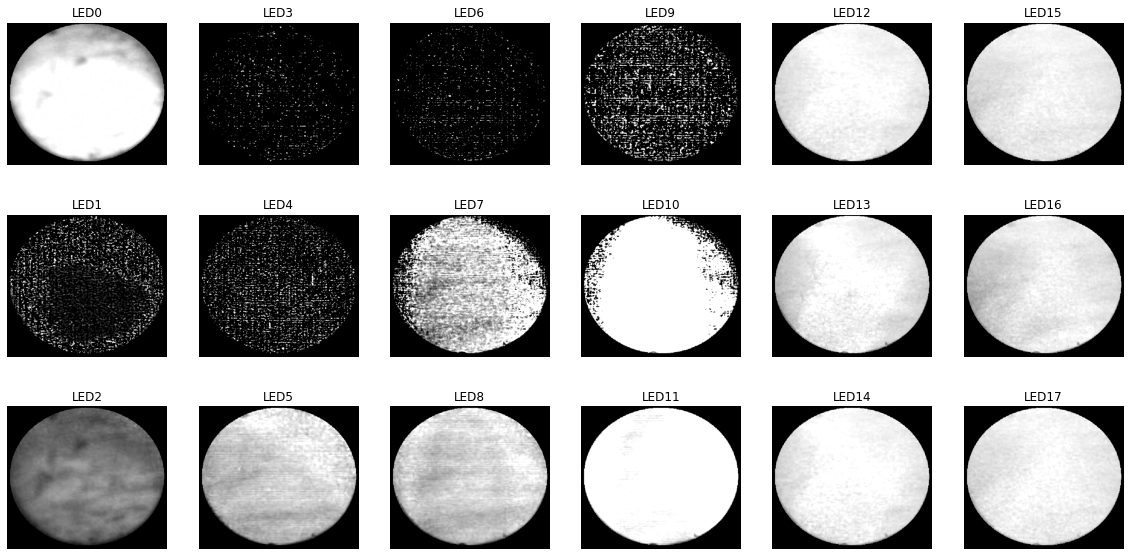

In [9]:
def set_figure_size():
    plt.figure(figsize=(20,10))

# [data_Gnum][NumOfPicture(LED)][picture(480*640*3)]
for Gnum in range(data_Gnum):
    print(" group {} ==================================".format(Gnum))

    set_figure_size()
    figure_index = 0
    for col in range(6):
        for row in range(3):
            plt.subplot(3,6,col+1+row*6)
            plt.axis("off")
            plt.title("LED{}".format(figure_index))

            # plt.imshow(data[Gnum][:,:,figure_index], plt.cm.gray, vmax=1.0)
            plt.imshow(reflectivity[Gnum][:,:,figure_index], plt.cm.gray, vmax=1.0)
            figure_index += 1
    plt.show()
    break


# del data witch we don't want

 group 0 ==================================


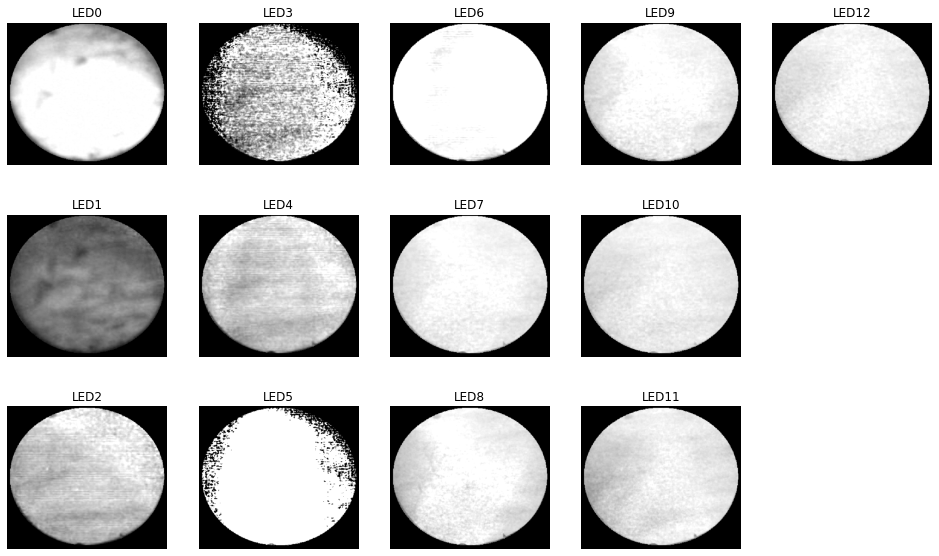

In [10]:
reflectivity_process = reflectivity
del reflectivity
reflectivity_process = np.delete(reflectivity_process,9,3)
reflectivity_process = np.delete(reflectivity_process,6,3)
reflectivity_process = np.delete(reflectivity_process,4,3)
reflectivity_process = np.delete(reflectivity_process,3,3)
reflectivity_process = np.delete(reflectivity_process,1,3)

def set_figure_size():
    plt.figure(figsize=(20,10))

# [data_Gnum][NumOfPicture(LED)][picture(480*640*3)]
for Gnum in range(data_Gnum):
    if(Gnum==1):
        break

    print(" group {} ==================================".format(Gnum))
    set_figure_size()
    figure_index = 0
    for col in range(6):
        for row in range(3):
            if(figure_index==13):
                break
            plt.subplot(3,6,col+1+row*6)
            plt.axis("off")
            plt.title("LED{}".format(figure_index))
            plt.imshow(reflectivity_process[Gnum][:,:,figure_index], plt.cm.gray, vmax=1.0)
            figure_index += 1
    plt.show()


In [11]:
# let data to be a spectral curve
print(reflectivity_process.shape)
reflectivity_process = reflectivity_process.transpose(0,3,1,2)
print(reflectivity_process.shape)
(group,band,x,y) = reflectivity_process.shape
reflectivity_process = reflectivity_process.reshape(group,band,x*y)
print(reflectivity_process.shape)

(144, 375, 420, 13)
(144, 13, 375, 420)
(144, 13, 157500)


In [12]:
mask_s = mask[20:-85,120:-100,0].reshape((1,375*420)) # mask_s = mask strip
print(mask_s.shape)

(1, 157500)


In [13]:
print(mask_s[0][9800])
print(np.linspace(1,13,13))
print(np.sum(np.linspace(1,13,13)))



1.0
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
91.0


In [14]:
total_point = np.count_nonzero(mask_s>0)
print(total_point)
reflectivity_p_s = np.zeros((data_Gnum,13),np.float)
print(reflectivity_p_s.shape)

print("process...")
for data_G in range(data_Gnum):
    for band in range(13):
        total = 0
        value = np.sum(reflectivity_process[data_G][band])/total_point
        reflectivity_p_s[data_G][band] = value
    print("{}/{}".format(data_G,data_Gnum),end='  ')


115148
(144, 13)
process...
0/144  1/144  2/144  3/144  4/144  5/144  6/144  7/144  8/144  9/144  10/144  11/144  12/144  13/144  14/144  15/144  16/144  17/144  18/144  19/144  20/144  21/144  22/144  23/144  24/144  25/144  26/144  27/144  28/144  29/144  30/144  31/144  32/144  33/144  34/144  35/144  36/144  37/144  38/144  39/144  40/144  41/144  42/144  43/144  44/144  45/144  46/144  47/144  48/144  49/144  50/144  51/144  52/144  53/144  54/144  55/144  56/144  57/144  58/144  59/144  60/144  61/144  62/144  63/144  64/144  65/144  66/144  67/144  68/144  69/144  70/144  71/144  72/144  73/144  74/144  75/144  76/144  77/144  78/144  79/144  80/144  81/144  82/144  83/144  84/144  85/144  86/144  87/144  88/144  89/144  90/144  91/144  92/144  93/144  94/144  95/144  96/144  97/144  98/144  99/144  100/144  101/144  102/144  103/144  104/144  105/144  106/144  107/144  108/144  109/144  110/144  111/144  112/144  113/144  114/144  115/144  116/144  117/144  118/144  119/144  12

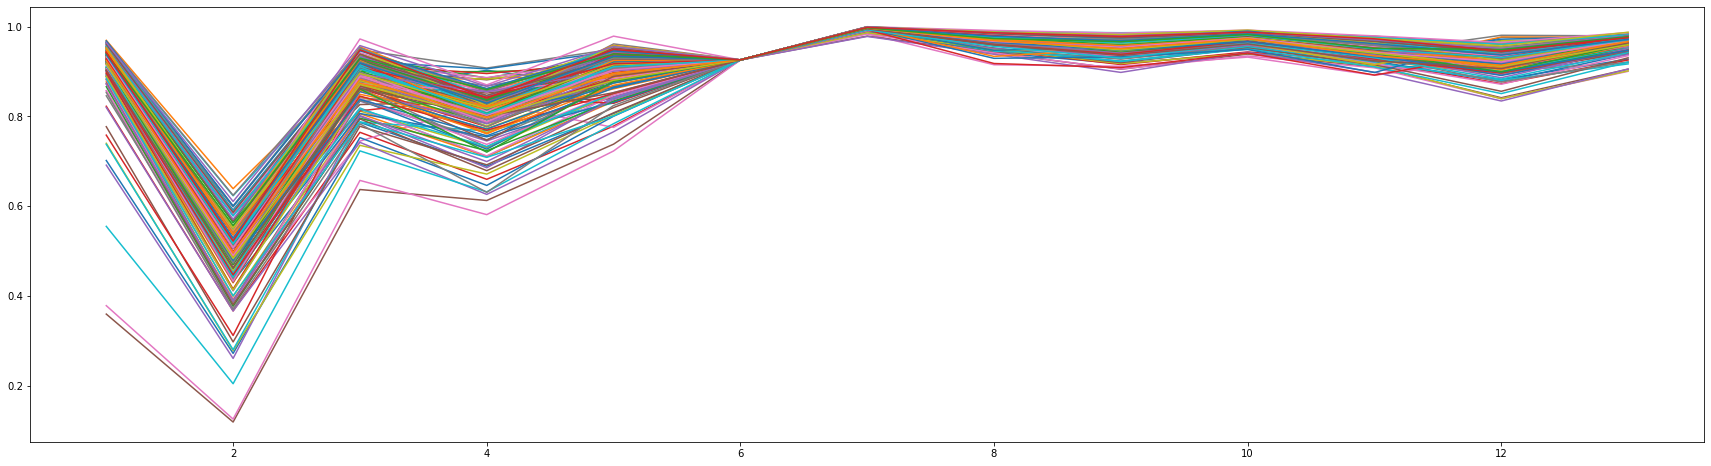

In [15]:
plt.figure(figsize=(30,8))
for data_G in range(data_Gnum):
    plt.plot(np.linspace(1,13,13),reflectivity_p_s[data_G])
    # clear_output(wait=True)
plt.show()

In [18]:
"""
 1.參數設定
"""
%matplotlib qt
xmin, xmax, A, N = 0, 4*np.pi, 4, 100
x = np.linspace(xmin, xmax, N)
y = A*np.sin(x)

"""
 2.繪圖
"""
fig = plt.figure(figsize=(7, 6), dpi=100)
ax = fig.gca()
line, = ax.plot(x, y, color='blue', linestyle='-', linewidth=3)
dot, = ax.plot([], [], color='red', marker='o', markersize=10, markeredgecolor='black', linestyle='')
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)

def update(i):
    dot.set_data(x[i], y[i])
    return dot,

def init():
    dot.set_data(x[0], y[0])
    return dot,

ani = animation.FuncAnimation(fig=fig, func=update, frames=N, init_func=init, interval=1000/N, blit=True, repeat=True)
plt.show()

# OSP

# t-SNE

In [ ]:
n_components = 2
perplexity = 43
early_exaggeration = 12.0
learning_rate = 40
n_iter = 400000
n_iter_without_progress = 300
min_grad_norm = 1e-07
metric = 'euclidean'
init = 'pca'
verbose = 1
random_state = None
method = 'barnes_hut'
angle = 0.5
n_jobs = None

tsne = manifold.TSNE(n_components=n_components, perplexity=perplexity, early_exaggeration=early_exaggeration,\
                     learning_rate=learning_rate, n_iter=n_iter, n_iter_without_progress=n_iter_without_progress,\
                     min_grad_norm=min_grad_norm, metric=metric, init=init, verbose=verbose,\
                     random_state=random_state, method=method, angle= angle, n_jobs=n_jobs)
tSNE_data = tsne.fit_transform(reflectivity_p_s)
file_name = "t-SNE_144_n{}_per{}_lr{}_iter{}".format(n_components,perplexity,learning_rate,n_iter)

print("\nOrg data dimension is {}\n\
Embedded data dimension is {}".format(reflectivity_p_s.shape, tSNE_data.shape))

'''嵌入空间可视化'''
data_min, data_max = tSNE_data.min(0), tSNE_data.max(0)
data_norm = (tSNE_data - data_min) / (data_max - data_min)  # 归一化


In [ ]:
# 2d
%matplotlib inline
colormap = plt.cm.rainbow(np.linspace(0, 1, data_norm.shape[0]))
plt.figure(figsize=(9, 9))
for i in range(data_norm.shape[0]):
    plt.text(data_norm[i, 0], data_norm[i, 1], str(i), color=colormap[i],
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([]); plt.yticks([]);
plt.savefig('d:/Special_topic/program/t-SNE_result/{}.png'.format(file_name))
plt.show()

# 3D
%matplotlib qt
colormap = plt.cm.rainbow(np.linspace(0, 1, data_norm.shape[0]))
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection='3d')
for i in range(data_norm.shape[0]):
    ax.text(data_norm[i,0], data_norm[i,1], data_norm[i,2],str(i), color=colormap[i])
    # ax.scatter(data_norm[i,0], data_norm[i,1], data_norm[i,2],str(i), cmap=colormap[i])

plt.savefig('d:/Special_topic/program/t-SNE_result/{}.png'.format(file_name))
plt.show()
